In [1]:
%matplotlib inline
import os
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

## Step 1 - Climate Analysis and Exploration

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

Fields
hawaii_measurements.csv are station, date, prcp, tobs...
dates are 1/1/10 - 8/23/17

hawaii_stations
station, name, latitude, longitude, elevation

## Precipitation Analysis

In [10]:
sel = [Measurement.date, Measurement.prcp]

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
mostRecentEntry = session.query(*sel).\
    order_by(Measurement.id.desc()).first()

pastYear = session.query(*sel).all()
mostRecentEntry

('2017-08-23', 0.45)

In [12]:
# Calculate the date 1 year ago from the last data point in the database
#Find the last entry
lastEntry = mostRecentEntry[0]
#lastEntry

#calculate the previous year by taking the year from the last entry and subtracting 1
lastYear = int(lastEntry[:4])-1
#lastYear

#take the year and add it to the day and month of the last entry as a string
yearAgo = str(lastYear)+lastEntry[4:]
yearAgo

'2016-08-23'

In [13]:
# Perform a query to retrieve the data and precipitation scores
#looking for data from dates between last entry and year ago 
precip = session.query(*sel).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= yearAgo).\
    order_by(Measurement.date).all()


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns = ["date", "precipitation"])
precip_df.sort_values('date')
# Sort the dataframe by date
precip_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


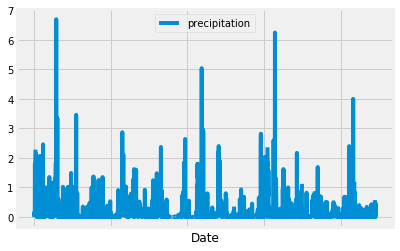

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.tick_params(axis='x', labelbottom=False)
#plt.ylabel('Precipitation')
plt.xlabel("Date")
plt.legend(loc = "upper center")
plt.savefig('./myImages/precipitation.png')
plt.show()

![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

## Station Analysis

In [20]:
# Design a query to show how many stations are available in this dataset?
numberOfStations = session.query(Station.id).count()
numberOfStations

9

In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationSel = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stationSel


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
mostActiveStation = stationSel[0][0]

print(f'Most Active Station is {mostActiveStation}.')

Most Active Station is USC00519281.


In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps = [func.min(Measurement.tobs),
         func.max(Measurement.tobs),
         func.avg(Measurement.tobs)]

tempData = session.query(*temps).\
    filter(Measurement.station==mostActiveStation).all()

print(f'The most active station is {mostActiveStation}.')
print(f'The lowest temperature recorded there was {tempData[0][0]}°F.')
print(f'The highest temperature recorded there was {tempData[0][1]}°F.')
print(f'The average temperature there was {round(tempData[0][2],1)}°F.')

The most active station is USC00519281.
The lowest temperature recorded there was 54.0°F.
The highest temperature recorded there was 85.0°F.
The average temperature there was 71.7°F.


In [50]:
# Choose the station with the highest number of temperature observations.
numTemp = [Measurement.date, Measurement.tobs]
tempObs = session.query(*numTemp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= yearAgo).\
    filter(Measurement.station == mostActiveStation).\
    order_by(Measurement.tobs).all()
#tempObs
# put results into dataframe
tempObs_df = pd.DataFrame(tempObs, columns = ['date', 'temperature'])
tempObs_df.sort_values('date')
tempObs_df.head()

,date,temperature
0,2017-02-02,59.0
1,2017-02-08,59.0
2,2017-02-09,59.0
3,2017-02-03,60.0
4,2017-04-30,60.0


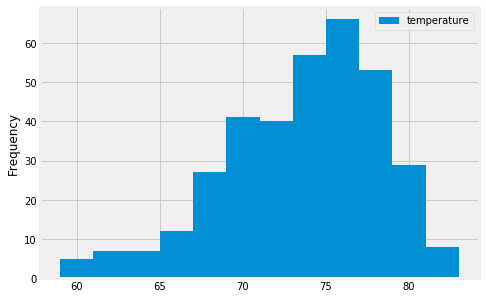

In [62]:
tempObs_df.plot.hist(bins=12, figsize = (7,5))
plt.savefig('./myImages/temperature_hist.png')
plt.show()

![precipitation](Images/station-histogram.png)

## Step 2 - Climate App

In [ ]:
# Design a Flask API based on the queries that you have just developed
# Use Flask to create your routes per instructions
from flask import Flask, jsonify

from sqlalchemy.orm import scoped_session, sessionmaker

#engine, Base and session were created in cells 5-9 above

####### FLASK SETUP ########
app = Flask(__name__)


In [ ]:
####### FLASK ROUTES #######

@app.route('/')
def welcome():
    """List all avalable api routes."""
    return (
        f'Avalable Routes:<br/>'
        f'/api/v1.0/precipitation<br/>'
        f'/api/v1.0/stations<br/>'
        f'/api/v1.0/tobs<br/>'
        f'/api/v1.0/<start><br/>'
        f'/api/v1.0/<start>/<end>'
    )
            
@app.route('/api/v1.0/precipitation')
def prcp():
    """Return a list of precipitation amounts."""
    #query precipitation amounts
    results = session.query(Measurement.precipitation).all()
    
    #convert list of tuples into normal list
    all_precipitation = list(np.ravel(results))
        
    return jsonify(all_precipitation)

@app.route('/api/v1.0/stations')
def station():
    """Return a list of stations"""
        
        
        

Fields hawaii_measurements.csv are station, date, prcp, tobs... dates are 1/1/10 - 8/23/17
hawaii_stations station, name, latitude, longitude, elevation

## Optional: Other Recommended Analyses

In [ ]:
#The following are optional challenge queries. 
#These are highly recommended to attempt, but not required for the homework.

## Temperature Analysis

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Daily Rainfall Average

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
